In [1]:
import torch
from torch import nn
from torch.nn import CrossEntropyLoss
from transformers import BartForConditionalGeneration, AutoTokenizer
import copy
import matplotlib.pylab as plt

In [2]:
model_checkpoint = "sshleifer/distilbart-cnn-6-6"
batch_size = 2
epochs = 4

In [3]:
torch.cuda.is_available()

True

In [4]:
!nvidia-smi

Tue Mar 22 01:25:08 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-PCIE-40GB      Off  | 00000000:01:00.0 Off |                    0 |
| N/A   30C    P0    38W / 250W |   1103MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  A100-PCIE-40GB      Off  | 00000000:41:00.0 Off |                    0 |
| N/A   

In [5]:
device = torch.device('cuda:4' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=4)

In [6]:
# define the function
def shift_tokens_right(input_ids: torch.Tensor, pad_token_id: int, decoder_start_token_id: int):
    """
    Shift input ids one token to the right.
    """
    shifted_input_ids = input_ids.new_zeros(input_ids.shape)
    shifted_input_ids[:, 1:] = input_ids[:, :-1].clone()
    shifted_input_ids[:, 0] = decoder_start_token_id

    if pad_token_id is None:
        raise ValueError("self.model.config.pad_token_id has to be defined.")
    # replace possible -100 values in labels by `pad_token_id`
    shifted_input_ids.masked_fill_(shifted_input_ids == -100, pad_token_id)

    return shifted_input_ids


# define the class
class MLT(nn.Module):
    
    def __init__(self, model_checkpoint):
      super(MLT, self).__init__()

      self.model = BartForConditionalGeneration.from_pretrained(model_checkpoint)
      self.tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

      self.encoder = self.model.get_encoder()

      self.decoder1 = self.model.get_decoder()
      self.decoder2 = copy.deepcopy(self.decoder1)

      self.lm_head1 = self.model.get_output_embeddings()
      self.lm_head2 = copy.deepcopy(self.lm_head1)

    def get_config(self):
      return self.model.config

    def get_decoder(self):
      return self.decoder1

    def get_lm_head(self):
      return self.lm_head1

    def get_final_logits_bias(self):
      return self.model.final_logits_bias

    def get_tokenizer(self):
      return self.tokenizer

    def forward(self, text, summary1, summary2):
      # inputs = self.tokenizer.encode(text, return_tensors="pt")
      # target1 = self.tokenizer.encode(summary1, return_tensors="pt")
      # target2 = self.tokenizer.encode(summary2, return_tensors="pt")

      inputs = text
      target1 = summary1
      target2 = summary2

      encoder_outputs = self.encoder(inputs)

      decoder_input_ids1 = shift_tokens_right(
                    target1, self.model.config.pad_token_id, self.model.config.decoder_start_token_id
                )
      
      decoder_input_ids2 = shift_tokens_right(
                    target2, self.model.config.pad_token_id, self.model.config.decoder_start_token_id
                )
      
      
      decoder_outputs1 = self.decoder1(
          decoder_input_ids1, 
          encoder_hidden_states=encoder_outputs[0], 
          use_cache = False,
          output_attentions=self.model.config.output_attentions,
          output_hidden_states=self.model.config.output_hidden_states,
          return_dict=self.model.config.use_return_dict,
          ) 

      decoder_outputs2 = self.decoder2(
          decoder_input_ids2, 
          encoder_hidden_states=encoder_outputs[0], 
          use_cache = False,
          output_attentions=self.model.config.output_attentions,
          output_hidden_states=self.model.config.output_hidden_states,
          return_dict=self.model.config.use_return_dict,
          )  

      lm_logits1 = self.lm_head1(decoder_outputs1[0]) + self.model.final_logits_bias
      lm_logits2 = self.lm_head2(decoder_outputs2[0]) + self.model.final_logits_bias   

      masked_lm_loss1 = None
      masked_lm_loss2 = None
      loss_fct = CrossEntropyLoss()
      masked_lm_loss1 = loss_fct(lm_logits1.view(-1, self.model.config.vocab_size), target1.view(-1))
      masked_lm_loss2 = loss_fct(lm_logits2.view(-1, self.model.config.vocab_size), target2.view(-1))
      
      # return {
      #     'loss1': masked_lm_loss1, 
      #     'loss2': masked_lm_loss2,
      #     'encoder_outputs': encoder_outputs
      #     }

      return (masked_lm_loss1, masked_lm_loss2, encoder_outputs)


# create the object
model = MLT(model_checkpoint)

In [7]:
model.to(device)

MLT(
  (model): BartForConditionalGeneration(
    (model): BartModel(
      (shared): Embedding(50264, 1024, padding_idx=1)
      (encoder): BartEncoder(
        (embed_tokens): Embedding(50264, 1024, padding_idx=1)
        (embed_positions): BartLearnedPositionalEmbedding(1026, 1024)
        (layers): ModuleList(
          (0): BartEncoderLayer(
            (self_attn): BartAttention(
              (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
            )
            (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (fc1): Linear(in_features=1024, out_features=4096, bias=True)
            (fc2): Linear(in_features=4096, out_features=1024, bias=True)
            (final_layer_norm): LayerNor

In [8]:
import pickle
with open('ami_short_fn.pkl', 'rb') as f:
    ami = pickle.load(f)

In [9]:
transcripts = ami['transcripts']
abs_summaries = ami['summaries']
ext_summaries = ami['summaries']


print(len(transcripts))
print(len(abs_summaries))
print(len(ext_summaries))

137
137
137


In [10]:
from sklearn.model_selection import train_test_split

train_transcripts, val_transcripts, train_abs_summaries, val_abs_summaries = train_test_split(transcripts, abs_summaries, test_size=.2)
_, _, train_ext_summaries, val_ext_summaries = train_test_split(transcripts, ext_summaries, test_size=.2)

In [11]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

train_transcripts_encodings = tokenizer(train_transcripts, truncation=True, padding=True)
val_transcripts_encodings = tokenizer(val_transcripts, truncation=True, padding=True)

with tokenizer.as_target_tokenizer():
  train_abs_summaries_encodings = tokenizer(train_abs_summaries, truncation=True, padding=True)
  val_abs_summaries_encodings = tokenizer(val_abs_summaries, truncation=True, padding=True)

  train_ext_summaries_encodings = tokenizer(train_ext_summaries, truncation=True, padding=True)
  val_ext_summaries_encodings = tokenizer(val_ext_summaries, truncation=True, padding=True)

In [12]:
class MeetDataset(torch.utils.data.Dataset):
    def __init__(self, transcripts, abs_summaries, ext_summaries):
        self.transcripts = transcripts
        self.abs_summaries = abs_summaries
        self.ext_summaries = ext_summaries

    def __len__(self):
        return len(self.transcripts.input_ids)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.transcripts.items()}
        item["abs"] = torch.tensor(self.abs_summaries["input_ids"][idx])
        item["ext"] = torch.tensor(self.ext_summaries["input_ids"][idx])
        return item

    

train_dataset = MeetDataset(train_transcripts_encodings, train_abs_summaries_encodings, train_ext_summaries_encodings)
val_dataset = MeetDataset(val_transcripts_encodings, val_abs_summaries_encodings, val_ext_summaries_encodings)

In [13]:
train_dataset.__len__(), val_dataset.__len__()

(109, 28)

In [14]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

In [15]:
from transformers import BartPretrainedModel
from transformers.modeling_outputs import Seq2SeqLMOutput

class DecoderForGeneration(BartPretrainedModel):

    def __init__(self, config, decoder, lm_head, final_logits_bias):
        super().__init__(config)
        
        self.config = config
        self.decoder = decoder
        self.lm_head = lm_head
        self.final_logits_bias = final_logits_bias

    # def get_encoder(self):
    #     return self.get_encoder()

    def get_decoder(self):
        return self.model.get_decoder()

    def resize_token_embeddings(self, new_num_tokens: int) -> nn.Embedding:
        new_embeddings = super().resize_token_embeddings(new_num_tokens)
        self._resize_final_logits_bias(new_num_tokens)
        return new_embeddings

    def _resize_final_logits_bias(self, new_num_tokens: int) -> None:
        old_num_tokens = self.final_logits_bias.shape[-1]
        if new_num_tokens <= old_num_tokens:
            new_bias = self.final_logits_bias[:, :new_num_tokens]
        else:
            extra_bias = torch.zeros((1, new_num_tokens - old_num_tokens), device=self.final_logits_bias.device)
            new_bias = torch.cat([self.final_logits_bias, extra_bias], dim=1)
        self.register_buffer("final_logits_bias", new_bias)

    def get_output_embeddings(self):
        return self.lm_head

    def set_output_embeddings(self, new_embeddings):
        self.lm_head = new_embeddings

    
    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        decoder_input_ids=None,
        decoder_attention_mask=None,
        head_mask=None,
        decoder_head_mask=None,
        cross_attn_head_mask=None,
        encoder_outputs=None,
        past_key_values=None,
        inputs_embeds=None,
        decoder_inputs_embeds=None,
        labels=None,
        use_cache=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        r"""
        labels (`torch.LongTensor` of shape `(batch_size, sequence_length)`, *optional*):
            Labels for computing the masked language modeling loss. Indices should either be in `[0, ...,
            config.vocab_size]` or -100 (see `input_ids` docstring). Tokens with indices set to `-100` are ignored
            (masked), the loss is only computed for the tokens with labels in `[0, ..., config.vocab_size]`.

        Returns:
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        if labels is not None:
            # if use_cache:
            #     logger.warning("The `use_cache` argument is changed to `False` since `labels` is provided.")
            use_cache = False
            if decoder_input_ids is None and decoder_inputs_embeds is None:
                decoder_input_ids = shift_tokens_right(
                    labels, self.config.pad_token_id, self.config.decoder_start_token_id
                )

        decoder_outputs = self.decoder(
        decoder_input_ids, 
        encoder_hidden_states=encoder_outputs[0], 
        use_cache = False,
        output_attentions=self.config.output_attentions,
        output_hidden_states=self.config.output_hidden_states,
        return_dict=self.config.use_return_dict,
        )
        lm_logits = self.lm_head(decoder_outputs[0]) + self.final_logits_bias

        masked_lm_loss = None
        if labels is not None:
            loss_fct = CrossEntropyLoss()
            masked_lm_loss = loss_fct(lm_logits.view(-1, model.config.vocab_size), labels.view(-1))

        if not return_dict:
            output = (lm_logits,) + decoder_outputs[1:]
            return ((masked_lm_loss,) + output) if masked_lm_loss is not None else output

        return Seq2SeqLMOutput(
            loss=masked_lm_loss,
            logits=lm_logits,
            past_key_values=decoder_outputs.past_key_values,
            decoder_hidden_states=decoder_outputs.hidden_states,
            decoder_attentions=decoder_outputs.attentions,
            cross_attentions=decoder_outputs.cross_attentions,
            encoder_last_hidden_state=encoder_outputs.last_hidden_state,
            encoder_hidden_states=encoder_outputs.hidden_states,
            encoder_attentions=encoder_outputs.attentions,
        )

    def prepare_inputs_for_generation(
        self,
        decoder_input_ids,
        past=None,
        attention_mask=None,
        head_mask=None,
        decoder_head_mask=None,
        cross_attn_head_mask=None,
        use_cache=None,
        encoder_outputs=None,
        **kwargs
    ):
        # cut decoder_input_ids if past is used
        if past is not None:
            decoder_input_ids = decoder_input_ids[:, -1:]

        return {
            "input_ids": None,  # encoder_outputs is defined. input_ids not needed
            "encoder_outputs": encoder_outputs,
            "past_key_values": past,
            "decoder_input_ids": decoder_input_ids,
            "attention_mask": attention_mask,
            "head_mask": head_mask,
            "decoder_head_mask": decoder_head_mask,
            "cross_attn_head_mask": cross_attn_head_mask,
            "use_cache": use_cache,  # change this to avoid caching (presumably for debugging)
        }

    def prepare_decoder_input_ids_from_labels(self, labels: torch.Tensor):
        return shift_tokens_right(labels, self.config.pad_token_id, self.config.decoder_start_token_id)

    @staticmethod
    def _reorder_cache(past, beam_idx):
        reordered_past = ()
        for layer_past in past:
            # cached cross_attention states don't have to be reordered -> they are always the same
            reordered_past += (
                tuple(past_state.index_select(0, beam_idx) for past_state in layer_past[:2]) + layer_past[2:],
            )
        return reordered_past


myDecoderModel = DecoderForGeneration(model.get_config(), model.get_decoder(), model.get_lm_head(), model.get_final_logits_bias())

In [16]:
myDecoderModel.to(device)

DecoderForGeneration(
  (decoder): BartDecoder(
    (embed_tokens): Embedding(50264, 1024, padding_idx=1)
    (embed_positions): BartLearnedPositionalEmbedding(1026, 1024)
    (layers): ModuleList(
      (0): BartDecoderLayer(
        (self_attn): BartAttention(
          (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
        )
        (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (encoder_attn): BartAttention(
          (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (out_proj): Linear(in_features=1024, out_features=1024, bias=Tru

In [17]:
from datasets import load_metric

metric = load_metric("rouge")

In [18]:
learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [19]:
import numpy as np
import nltk
nltk.download('punkt')
def train(model, train_loader, validation_loader, optimizer, epochs=100):
    i = 0
    useful_stuff = {'training_loss': [], 'validation_loss': []}  
    
    for epoch in range(epochs):
        print(epoch)
        # model.train()
        for i, data in enumerate(train_loader):
            data['input_ids'], data['abs'], data['ext'] = data['input_ids'].to(device), data['abs'].to(device), data['ext'].to(device)
            optimizer.zero_grad()
            output = model(data['input_ids'], data['abs'], data['ext'])
            loss = output[0] + output[1]
            loss.backward()
            optimizer.step()
            useful_stuff['training_loss'].append(loss.item())
            print(loss.item())

        print("Validation")
        model.eval()
        for i, data in enumerate(validation_loader):
            with torch.no_grad():
              data['input_ids'], data['abs'], data['ext'] = data['input_ids'].to(device), data['abs'].to(device), data['ext'].to(device)
              output = model(data['input_ids'], data['abs'], data['ext'])
              loss = output[0] + output[1]
              useful_stuff['validation_loss'].append(loss.item())
              print(loss.item())

              predictions = myDecoderModel.generate(data['input_ids'], encoder_outputs=output[2])
              labels = data['abs'].cpu()

              decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
              print(decoded_preds)
              # Replace -100 in the labels as we can't decode them.
              labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
              decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
              
              # Rouge expects a newline after each sentence
              decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_preds]
              decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels]

              metric.add_batch(predictions=decoded_preds, references=decoded_labels)
              
        result = metric.compute(use_stemmer=True)
        # Extract a few results from ROUGE
        result = {key: value.mid.fmeasure * 100 for key, value in result.items()}

        result = {k: round(v, 4) for k, v in result.items()}
    
    return (useful_stuff, result)

training_results = train(model, train_loader, validation_loader, optimizer, epochs=epochs)

[nltk_data] Downloading package punkt to
[nltk_data]     /home/tanik_1821cs08/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


0
20.050567626953125
19.67141342163086
12.34854507446289
7.986984729766846
3.945970058441162
4.508349418640137
4.688532829284668
2.630837917327881
3.362532615661621
4.64561653137207
3.955313205718994
3.1837563514709473
2.8125081062316895
3.063981533050537
5.005764961242676
3.4633374214172363
3.200277805328369
4.723169803619385
2.412905216217041
2.7187819480895996
3.6341030597686768
3.0725016593933105
4.074567794799805
3.4020702838897705
3.3782453536987305
2.3107619285583496
3.3189635276794434
2.806607723236084
3.8812451362609863
3.235157012939453
1.8468313217163086
4.163167953491211
3.5049078464508057
2.9882895946502686
3.2973875999450684
2.5251567363739014
3.7760796546936035
2.6819345951080322
4.389279842376709
3.5966134071350098
3.1827025413513184
3.178431510925293
4.092580795288086
1.9698164463043213
2.3461854457855225
2.561826229095459
3.8248953819274902
4.129302024841309
3.070645570755005
2.9223620891571045
3.6710407733917236
3.72529673576355
4.40413236618042
4.017650127410889
3.4

["The prototype presentation was presented by the Industrial Designer. The Industrial Designer presented the prototype presentation of the prototype. The industrial Designer discussed the budget for the project. The group discussed the project's budget and budget options. The team discussed the cost of the project, the amount of time they spent on the prototype, and how they would like to use the remote. They discussed the possibility of using the remote as a remote. The project manager suggested that the remote could be used for the remote, but the industrial designer suggested that it should be used on the remote for the power. The designers discussed the need for a remote with the remote to be able to be used in the remote with a remote that is", 'The project manager opened the meeting with a presentation of the meeting agenda. The industrial designer opened the presentation with a PowerPoint presentation. The project manager gave the presentation to the industrial designer. The tea

['The project manager and the marketing expert discussed the needs of the project manager. The marketing expert and the industrial designer discussed the market market potential for the remote. The project manager discussed the need to find out if the market will be willing to pay more for the product. The industrial designer and marketing expert also discussed the cost of the remote control. The group decided that the product should be designed to appeal to the market. The team decided that they should be able to sell the product to the consumers. They decided that it should be more affordable. They were able to make a profit out of their profits out of the design and marketing. They discussed the potential of the product and marketing potential. The meeting', 'The Project Manager will present the prototype to the group. The User Interface Designer will also present the project manager and the designer will present them to the team. The Industrial Designer will then present the team w

["The project manager opened the meeting and opened the agenda. The industrial designer introduced the project manager and the industrial designer. The marketing expert opened the group's agenda and gave the group a brief overview of the project. The group then opened their agenda and discussed their ideas for the remote control. The project manager then opened the project with the group discussing their ideas. The team discussed the idea of using a power cradle to power the remote. They discussed using solar cells, and how they would like to use a rubber-powered device. They also discussed using a rubber rubber device and rubber rubber. They decided to use the rubber rubber to make the remote more environmentally friendly. They then decided to make a rubber", "The project manager opened the meeting and discussed the components concept. The industrial designer discussed the case material, the case materials, and the user interface. The user interface designer discussed how to represent

['The project manager opened the meeting and opened the agenda. The project manager then opened the project and gave the project manager a brief overview of the project. The industrial designer presented the technical functions and the user interface interface. The user interface designer explained that the remote control is not specialised and that it is not a specialised technology. The marketing expert presented the project management brief. The group then discussed the technical requirements of the product design. They discussed the marketing strategy. They decided that they should not have to change the remote design. The team decided that it should not change the design of the remote. The remote will not be specialised because it is too expensive. It will be easy to make', 'The project manager introduced the project and opened the project meeting. The project manager opened the meeting and gave the project manager a brief overview of the project. The marketing expert was the mark

2
3.5955095291137695
2.7185332775115967
2.2509241104125977
2.3093364238739014
2.342001438140869
3.42808198928833
3.131229877471924
3.7688865661621094
3.0155277252197266
2.4783267974853516
2.641744613647461
3.9125280380249023
2.125175952911377
2.806365966796875
2.584122896194458
3.3255205154418945
2.704538345336914
3.909972667694092
1.9433109760284424
2.96207332611084
2.208346128463745
2.5234241485595703
2.6161298751831055
2.0940988063812256
2.7323498725891113
2.587157726287842
2.085453748703003
2.592564105987549
1.7368220090866089
2.5565805435180664
3.765444278717041
2.628582239151001
2.317617893218994
2.35506272315979
2.90718936920166
2.6070713996887207
1.8455359935760498
3.195533514022827
2.153805732727051
3.4556679725646973
2.4307851791381836
2.1753435134887695
3.714446544647217
1.9771852493286133
2.4267807006835938
3.3526084423065186
2.486832857131958
2.51149320602417
2.5270586013793945
3.023141860961914
3.512624979019165
3.768239974975586
2.5543313026428223
2.035172939300537
2.701

["The project manager and industrial designer presented the prototype presentation. They discussed the project budget for the project. The project manager presented the project manager's agenda for the meeting. The industrial designer explained that the prototype was based on a mango-themed design. The marketing expert presented the product to the industrial designer. The group discussed their budget for their product. The team then discussed the product's features, which included an LCD screen, and how to make it look like a remote. The interface designer presented a prototype of the prototype. The user interface designer discussed the prototype and the group discussed how they would like to make the device look like they were using a fruit-themed fruit. The Industrial Designer", 'The project manager opened the meeting by saying that the project manager had a meeting agenda. The project manager then opened the project meeting by stating that the team had decided that they wanted an er

["The Project Manager and the Industrial Designer presented the project manager and the industrial designer. The industrial designer and the marketing expert presented their findings on the project. The project manager discussed the project management role role of each member of the project team. The marketing expert discussed the role of the group and the group members. The group then discussed the group's role role role roles. The team then discussed their roles in the marketing and project management. They discussed their role in the project process. They decided that the group should be able to work together to create a product that could be used in the future. They also discussed how they would like to use a remote control. They then decided that they should", 'The project manager presented the project manager and the industrial designer. The industrial designer presented the prototype prototype. The project manager showed the prototype to the group. The group then discussed the p

['The project manager opened the meeting by saying that the team had all broken a remote control. The industrial designer opened the project by stating that he was an old man and that the project manager was a young man. The project manager then introduced the industrial designer and the marketing expert. The team then discussed the features of the remote, which included a rubber rubber case, and the case material. The group then decided to use the rubber case to make the remote more environmentally friendly. The marketing expert suggested that the case case should be made of rubber, rubber, and rubber.The industrial designer will work on the case design.The team will use a rubber case.The remote will use solar cells.The', 'The project manager opened the meeting and discussed the functional design of the remote. The industrial designer presented the components concept and presented the case material. The user interface designer presented her ideas on the user interface. The group then 

['The project manager opened the meeting by stating that the remote is not currently working. The industrial designer presented the technical functions of the remote and the user interface. The user interface designer discussed the technical requirements of the project. The marketing expert presented the project requirements and the project manager presented the functional design. The project manager gave the project budget for the project and the budget. The group then discussed the project costs. The remote will be sold at the end of the year.The remote will cost between $20 and $100.The group will not be able to afford to meet all the requirements.The team will work on a prototype.The prototype will be made of plastic, plastic and plastic.The', 'The project manager introduced the project and the project manager and the marketing expert. The project manager opened the meeting by stating that the project was going to be a success. The marketing expert and the user interface designer w

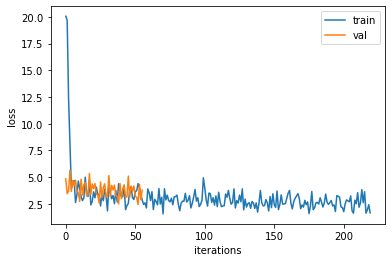

In [20]:
plt.plot(training_results[0]['training_loss'], label="train")
plt.plot(training_results[0]['validation_loss'], label="val")
plt.ylabel('loss')
plt.xlabel('iterations')
plt.legend()
#plt.title('training loss iterations')

In [21]:
training_results[1]

{'rouge1': 40.203, 'rouge2': 16.3304, 'rougeL': 24.1974, 'rougeLsum': 38.3591}

In [ ]:
!nvidia-smi